The code begins by setting up the necessary libraries required for data manipulation, image processing, and building a deep learning model.
Ongoing Progress: Experimenting to find the best custom model architecture.

In [8]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

**Loading the data**

In [9]:
traindf = pd.read_csv("../input/landmark-recognition-2021/train.csv")

In [10]:
traindf.head()

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7


In [11]:
traindf.shape # 1.5M Images

(1580470, 2)

**Extracting Limited(50) Unique Landmarks and Corresponding Image IDs**

In [12]:
landmark_unique = traindf['landmark_id'].unique()[0:50]
image_ids = []
labels = []
temp_labels = []

for i, id_ in enumerate(landmark_unique):
    for iid in traindf['id'][traindf['landmark_id'] == id_]:
        image_ids.append(iid)
        labels.append(id_)
        temp_labels.append(i)

**Image Loading and Resizing for Landmark Recognition Dataset**

In [13]:
mainpath = '../input/landmark-recognition-2021/train'
images_pixels = []

for iid in image_ids:
    first_dir = os.path.join(mainpath, iid[0])
    second_dir = os.path.join(first_dir, iid[1])
    third_dir = os.path.join(second_dir, iid[2])
    finalpath = os.path.join(third_dir, iid + '.jpg')
    
    img_pix = cv2.imread(finalpath, 1)
    images_pixels.append(cv2.resize(img_pix, (100, 100)))

In [14]:
X_data = np.array(images_pixels) / 255.0
Y_data = to_categorical(temp_labels, num_classes=50)

In [15]:
# We are in the development phase and only care about training and validation for now.
# We will create a separate test set later or use a different dataset for testing.
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data, test_size=0.3, random_state=101)

In [34]:
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(800, 100, 100, 3)
(344, 100, 100, 3)
(800, 50)
(344, 50)


**Displaying a Subset of Training Images with Labels**

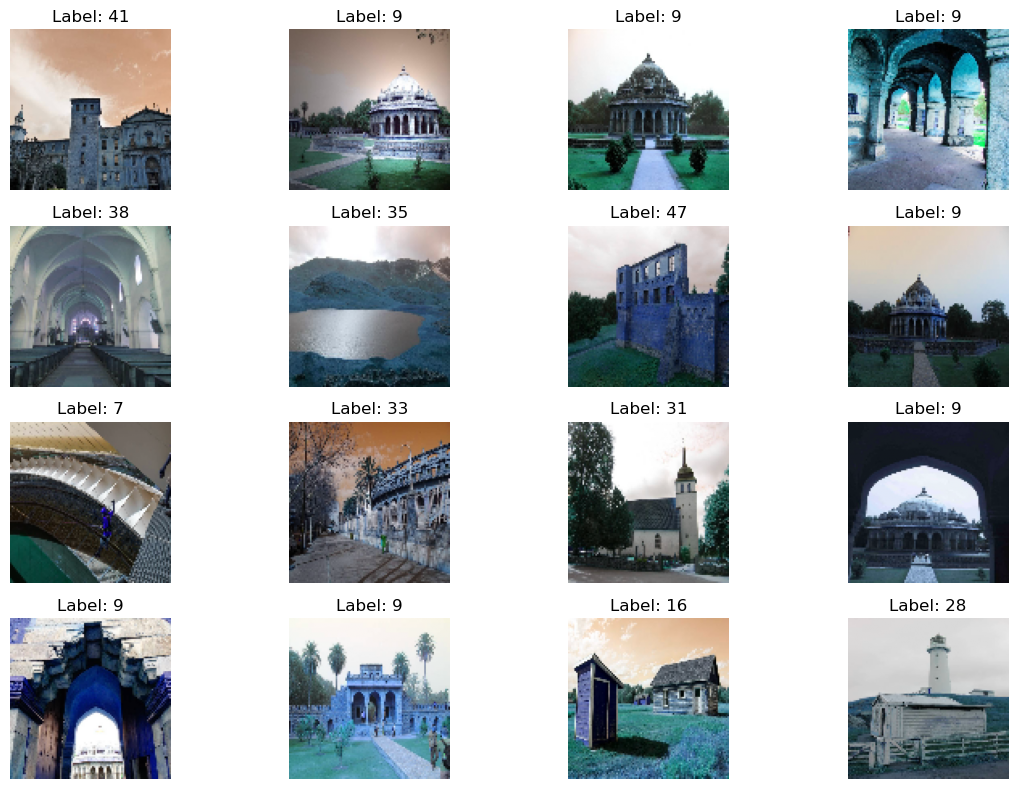

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_train[i])
    plt.title(f"Label: {np.argmax(Y_train[i])}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

**MobileNetV2 Model Initialization**

MobileNetV2 architecture, a lightweight deep learning model known for its efficiency in mobile vision applications, recognizes landmarks from images.

In [17]:
base_model = MobileNetV2(input_shape=(100,100,3), include_top=False, weights='imagenet', pooling='avg')
base_model.trainable = False # Feature extractor is freezed, only newly added layers will be trained

9406464/9406464 [==============================] - 0s 0us/step


**Other Model Test**

In [35]:
pretrained_model = tf.keras.applications.DenseNet201(input_shape=(100,100,3),
                                                      include_top=False,
                                                      weights='imagenet',
                                                      pooling='avg')
pretrained_model.trainable = False

74836368/74836368 [==============================] - 0s 0us/step


In [37]:
inputs = pretrained_model.input
drop_layer = tf.keras.layers.Dropout(0.25)(pretrained_model.output)
x_layer = tf.keras.layers.Dense(512, activation='relu')(drop_layer)
x_layer1 = tf.keras.layers.Dense(128, activation='relu')(x_layer)
drop_layer1 = tf.keras.layers.Dropout(0.20)(x_layer1)
outputs = tf.keras.layers.Dense(50, activation='softmax')(drop_layer1)


model2 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [39]:
# model2.summary()

In [40]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['acc'])
history = model2.fit(datagen.flow(X_train,Y_train,batch_size=32),validation_data=(X_val,Y_val),epochs=30)

Epoch 1/30
25/25 [==============================] - 20s 299ms/step - loss: 2.7175 - acc: 0.4412 - val_loss: 1.9287 - val_acc: 0.5407
Epoch 2/30
25/25 [==============================] - 2s 92ms/step - loss: 1.8617 - acc: 0.5487 - val_loss: 1.5338 - val_acc: 0.6076
Epoch 3/30
25/25 [==============================] - 2s 91ms/step - loss: 1.4401 - acc: 0.6162 - val_loss: 1.3333 - val_acc: 0.6512
Epoch 4/30
25/25 [==============================] - 2s 91ms/step - loss: 1.1296 - acc: 0.7175 - val_loss: 1.1088 - val_acc: 0.7267
Epoch 5/30
25/25 [==============================] - 2s 98ms/step - loss: 0.8640 - acc: 0.7837 - val_loss: 0.9950 - val_acc: 0.7355
Epoch 6/30
25/25 [==============================] - 2s 92ms/step - loss: 0.7501 - acc: 0.7825 - val_loss: 0.8296 - val_acc: 0.7703
Epoch 7/30
25/25 [==============================] - 2s 94ms/step - loss: 0.5882 - acc: 0.8313 - val_loss: 0.8529 - val_acc: 0.7645
Epoch 8/30
25/25 [==============================] - 2s 91ms/step - loss: 0.4679 -

**Adding Custom Layers to MobileV2 architecture**

In [18]:
x = base_model.output
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(50, activation='softmax')(x)

**Compiling the Landmark Recognition Model**

In [19]:
model = Model(inputs=base_model.input, outputs=predictions)

In [20]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

**Image Data Augmentation Configuration**

In [21]:
datagen = ImageDataGenerator(horizontal_flip=False,
                             vertical_flip=False,
                             rotation_range=0,
                             zoom_range=0.2,
                             width_shift_range=0,
                             height_shift_range=0,
                             shear_range=0,
                             fill_mode="nearest")

**Training the Landmark Recognition Model with Data Augmentation**

In [22]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size=32),
                    validation_data=(X_val, Y_val),
                    epochs=30)

Epoch 1/30
25/25 [==============================] - 11s 142ms/step - loss: 2.8700 - acc: 0.4275 - val_loss: 2.0688 - val_acc: 0.5000
Epoch 2/30
25/25 [==============================] - 2s 79ms/step - loss: 1.9130 - acc: 0.5400 - val_loss: 1.5752 - val_acc: 0.6076
Epoch 3/30
25/25 [==============================] - 2s 86ms/step - loss: 1.4702 - acc: 0.6338 - val_loss: 1.3620 - val_acc: 0.6599
Epoch 4/30
25/25 [==============================] - 2s 78ms/step - loss: 1.0702 - acc: 0.7275 - val_loss: 1.2042 - val_acc: 0.6860
Epoch 5/30
25/25 [==============================] - 2s 77ms/step - loss: 0.8386 - acc: 0.7763 - val_loss: 1.1096 - val_acc: 0.7384
Epoch 6/30
25/25 [==============================] - 2s 79ms/step - loss: 0.6328 - acc: 0.8325 - val_loss: 0.9205 - val_acc: 0.7413
Epoch 7/30
25/25 [==============================] - 2s 78ms/step - loss: 0.5026 - acc: 0.8600 - val_loss: 0.9496 - val_acc: 0.7297
Epoch 8/30
25/25 [==============================] - 2s 79ms/step - loss: 0.3882 -

In [23]:
y_pred = model.predict(X_val) # Make predictions on X_val data

11/11 [==============================] - 1s 11ms/step


In [24]:
Y_val.shape

(344, 50)

In [26]:
# Convert Y_val (one-hot) to class indices
y_true = np.argmax(Y_val, axis=1) # Derived from Y_val

# The raw predictions (probabilities) from the model
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure y_pred_classes is already in class indices format
print("y_true shape:", y_true.shape)
print("y_pred_classes shape:", y_pred_classes.shape)

y_true shape: (344,)
y_pred_classes shape: (344,)


In [27]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Print or visualize the confusion matrix
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[1 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 9 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


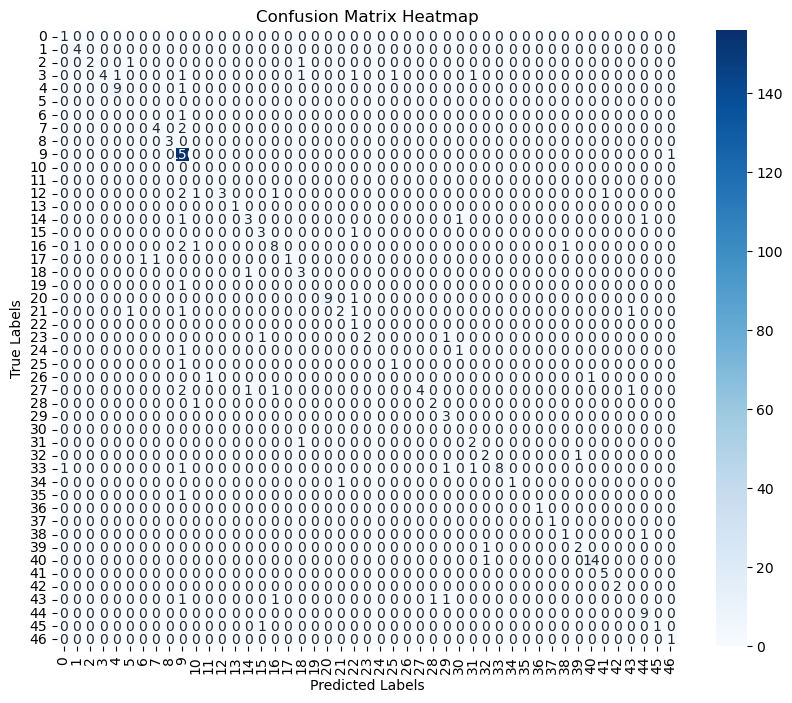

In [28]:
# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [30]:
# Initialize arrays to store metrics for each class
num_classes = cm.shape[0]  # Number of classes (50 in this case)
TP = []
TN = []
FP = []
FN = []

# Calculate metrics for each class
for i in range(num_classes):
    tp = cm[i, i]  # True Positives
    fp = cm[:, i].sum() - tp  # False Positives
    fn = cm[i, :].sum() - tp  # False Negatives
    tn = cm.sum() - (tp + fp + fn)  # True Negatives

    # Append to lists
    TP.append(tp)
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)

# Convert to arrays for easier handling if needed
TP = np.array(TP)
TN = np.array(TN)
FP = np.array(FP)
FN = np.array(FN)

In [31]:
# Display the metrics for each class
for i in range(num_classes):
    print(f"Class {i}: TP={TP[i]}, TN={TN[i]}, FP={FP[i]}, FN={FN[i]}")


Class 0: TP=1, TN=342, FP=1, FN=0
Class 1: TP=4, TN=339, FP=1, FN=0
Class 2: TP=2, TN=340, FP=0, FN=2
Class 3: TP=4, TN=334, FP=0, FN=6
Class 4: TP=9, TN=333, FP=1, FN=1
Class 5: TP=0, TN=342, FP=2, FN=0
Class 6: TP=0, TN=342, FP=1, FN=1
Class 7: TP=4, TN=337, FP=1, FN=2
Class 8: TP=3, TN=341, FP=0, FN=0
Class 9: TP=156, TN=168, FP=19, FN=1
Class 10: TP=0, TN=341, FP=3, FN=0
Class 11: TP=0, TN=343, FP=1, FN=0
Class 12: TP=3, TN=336, FP=0, FN=5
Class 13: TP=1, TN=343, FP=0, FN=0
Class 14: TP=3, TN=336, FP=2, FN=3
Class 15: TP=3, TN=338, FP=2, FN=1
Class 16: TP=8, TN=328, FP=3, FN=5
Class 17: TP=1, TN=341, FP=0, FN=2
Class 18: TP=3, TN=337, FP=3, FN=1
Class 19: TP=0, TN=343, FP=0, FN=1
Class 20: TP=9, TN=334, FP=0, FN=1
Class 21: TP=2, TN=337, FP=1, FN=4
Class 22: TP=1, TN=339, FP=4, FN=0
Class 23: TP=2, TN=340, FP=0, FN=2
Class 24: TP=0, TN=342, FP=0, FN=2
Class 25: TP=1, TN=341, FP=1, FN=1
Class 26: TP=0, TN=342, FP=0, FN=2
Class 27: TP=4, TN=335, FP=0, FN=5
Class 28: TP=2, TN=340, FP=

**Model Visualization**

Text(0.5, 1.0, 'Training and Validation Accuracy')

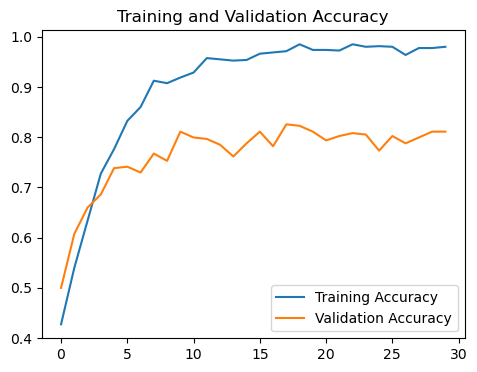

In [32]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')


Text(0.5, 1.0, 'Training and Validation Loss')

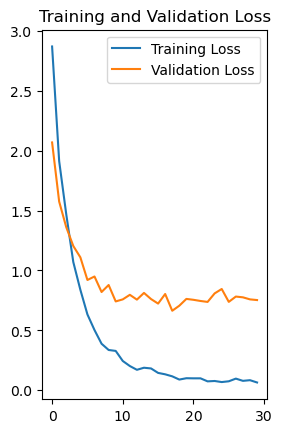

In [33]:
# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')


Notebook referenced from this user https://www.kaggle.com/mrigendrachauhan